# **Project Overview:**

## Objective: 
Develop a classification model to predict the potability of water based on its physicochemical properties. The goal is to determine whether a given sample of water is safe for consumption (potable) or not, using various features like pH level, hardness, solids, and other water quality metrics.

## Data Description,
The water_potability.csv file contains water quality measurements for 3,276 different water bodies. It includes 9 feature variables, with a target variable called potability (1 indicating the water is potable and 0 indicating it is not).

Source:  [https://www.kaggle.com/datasets/adityakadiwal/water-potability/data](https://www.kaggle.com/datasets/adityakadiwal/water-potability/data)

## Import Libraries

In [2]:
# EDA
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Scalars and Model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold, cross_validate, RepeatedKFold, cross_val_predict
from sklearn.impute import KNNImputer # preprocessing for missing value
from imblearn.over_sampling import SMOTE, ADASYN # preprocessing for oversampling
from imblearn.under_sampling import RandomUnderSampler


from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler # preprocessing for Standardization
from sklearn.decomposition import PCA # preprocessing for dimensional reduction

 #Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.pipeline import make_pipeline # pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay, make_scorer, f1_score, fbeta_score, precision_recall_curve, recall_score



## Load Dataset

In [3]:
data_water = pd.read_csv("../data/water_quality_prediction_data/water_potability.csv", index_col=None)
data_ori = data_water.copy()

## Explanatory Data Analysis (EDA)

In [4]:
# Quck overview of the data
data_water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
data_water.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
ph,2785.000000,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.000000,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.000000,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.000000,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.000000,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.000000,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.000000,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.000000,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.000000,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.000000,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


### Class Distribution

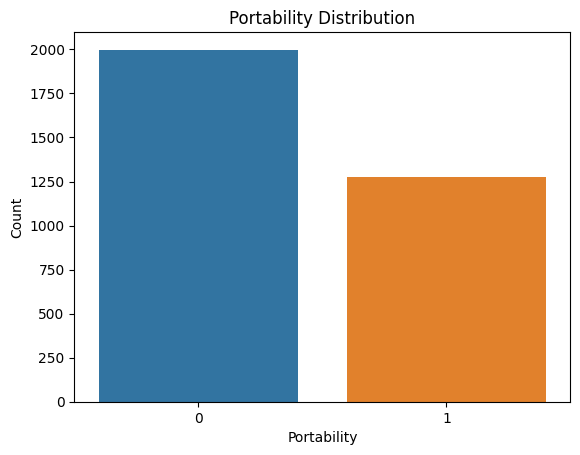

Potability
0    1998
1    1278
Name: count, dtype: int64

In [6]:
sns.countplot(x='Potability', data=data_water)
plt.title('Portability Distribution')
plt.xlabel('Portability')
plt.ylabel('Count')
plt.show()

data_water["Potability"].value_counts()


## Data Preprocessing
### Handling Missing Values and Duplicate Rows

In [7]:
# Identify a missing data
data_water.isnull().sum()/len(data_water)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

In [8]:
# Validate for duplicate data entries
data_water.duplicated().sum()

0

In [9]:
target = 'Potability'
missing = 'Sulfate'

X = data_water.drop(columns=[target])
y = data_water[target]

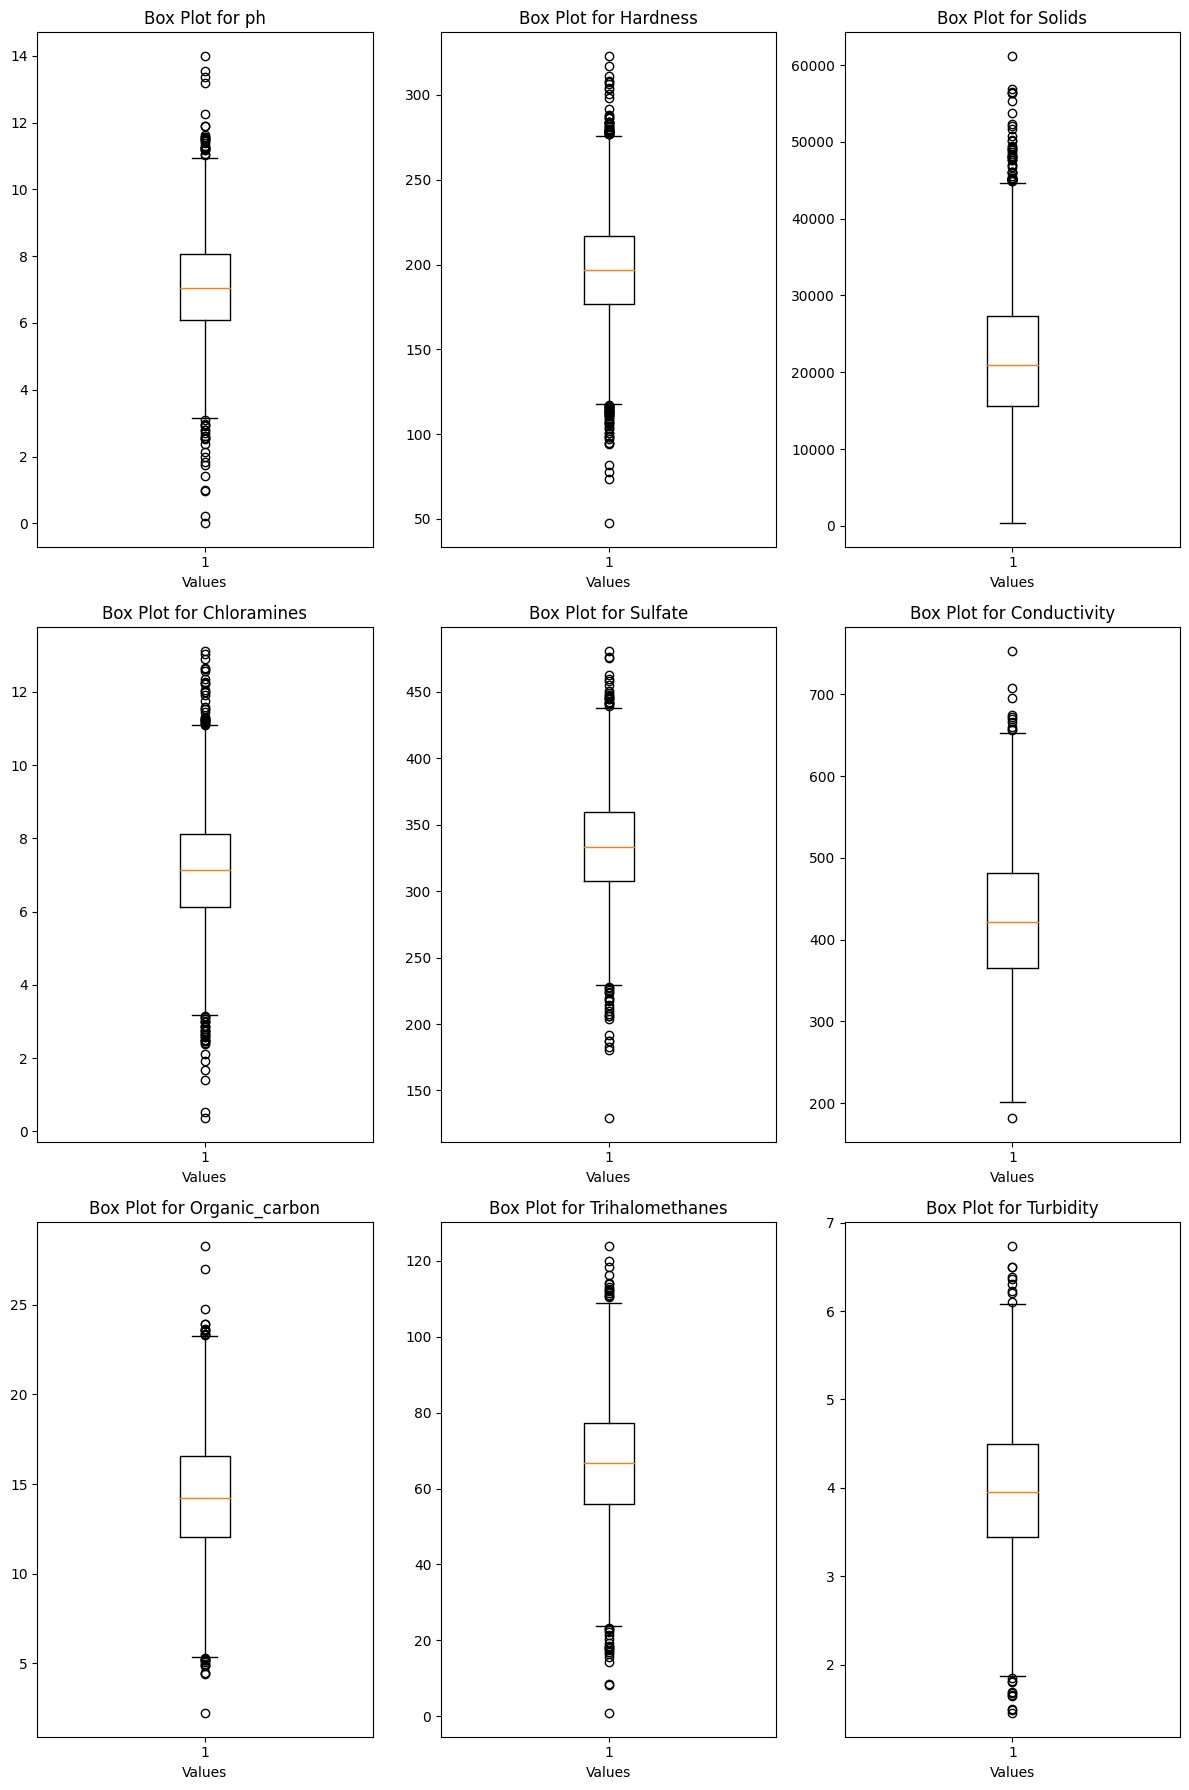

In [10]:
# Set the figure size for the subplots
plt.figure(figsize=(12,18))

# Iterate through the columns and create individual box plots
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, len(X.columns) //3, i)  # Create a subplot for each column
    plt.boxplot(X[column].dropna())
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('')
    

plt.tight_layout()  # Adjust subplot spacing

plt.show()

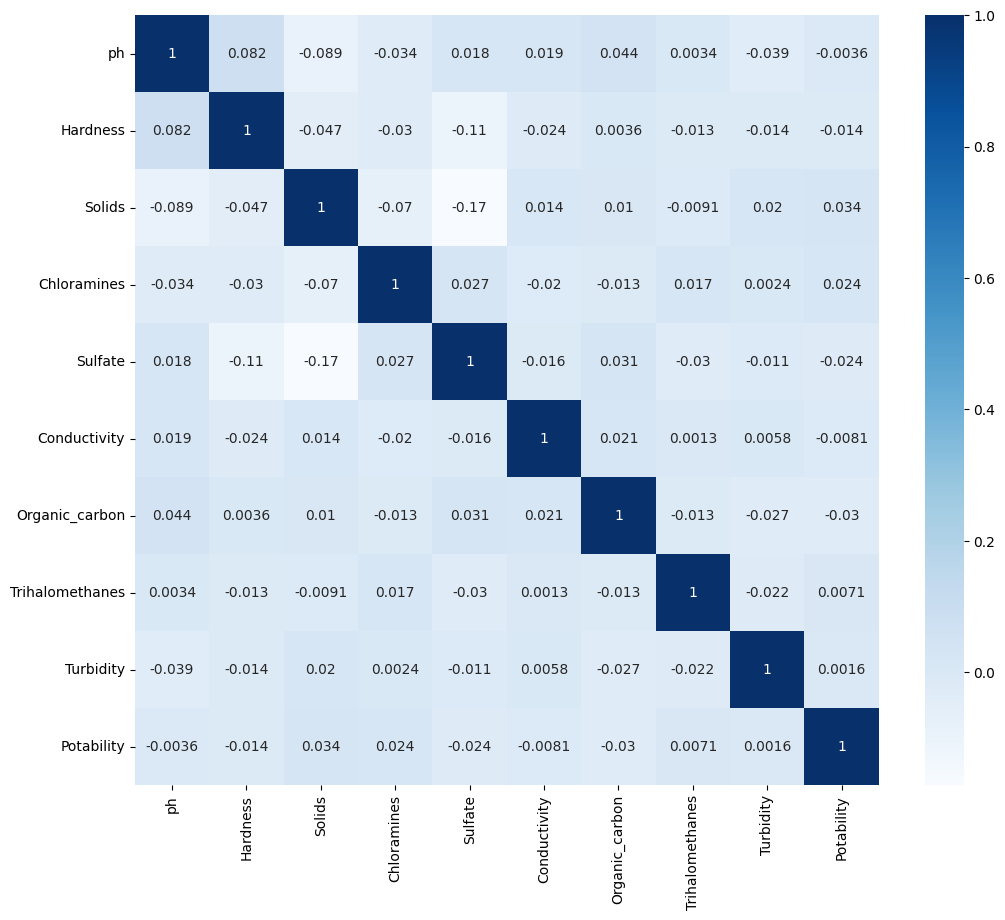

In [11]:
plt.figure(figsize=(12,10))
cor = data_water.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()


### Feature Scaling and Data Balancing

In our exploratory data analysis, we identified several important aspects for the upcoming analysis:

small correlation between variables: the dimesnion reduction would be not recommend for the preprocessing steps

Target Imbalance: The target variable shows a pronounced imbalance with a 1998:1278 ratio, where the negative class dominates.

- StratifiedKFold for Cross-Validation: 
Given this class imbalance, we’ll use StratifiedKFold, a variant of k-fold cross-validation. This approach ensures each fold maintains the same class distribution as the original dataset, supporting a more balanced evaluation.

- F1 Score and Recall as Key Metrics:
Given the imbalanced nature of the data, the F1 score is prioritized over accuracy as the primary evaluation metric. In the context of water quality, minimizing false negatives is critical to prevent people from consuming unsafe water. Therefore, recall will be closely monitored to ensure the accurate identification of positive cases, reducing the risk of undetected contamination.


In [55]:
def build_pipeline(scalar = True, imputer = True, smote = True, model = None):
    """
    A function that takes a model as an argument and returns the full pipeline.
    """
    steps = []
    if scalar:
        steps.append(('scaler', RobustScaler()))
    if imputer:
        steps.append(('imputer', KNNImputer(missing_values=np.nan)))
    if smote:
        steps.append(('smote', SMOTE()))
    if model is not None:
        steps.append(('model', model))
    
    return Pipeline(steps)

In [148]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

classifiers = [
    ('K Neighbors Classifier', KNeighborsClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=33)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=33)),
    ('SVC',SVC(random_state =33)),
    ('Gaussian NB',GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state =33)),
]

scoring = {
    'precision': make_scorer(precision_score, zero_division=1)  ,
    'f1' : make_scorer(f1_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1)
}

skf = StratifiedKFold(n_splits=10, shuffle= True,  random_state=33)


In [114]:
class bar_chart:
    """
    A function that generates a bar chart from cross-validated data.    
    """
    def __init__(self, addin_title=""):
        self.addin_title = addin_title

    def draw_chart(self,input):
        rounded_input = [[item if isinstance(item, str) else round(item, 2) for item in row] for row in input]

        df_bar = pd.DataFrame(rounded_input, columns=['Model', 'Precision', 'Recall', 'f1'])
        df_bar.sort_values(by='f1', inplace=True, ascending=False)

        # Melt the DataFrame for Seaborn
        df_melted = df_bar.melt(id_vars='Model', var_name='Metric', value_name='Value')


        plt.figure(figsize=(14, 6))
        ax = sns.barplot(data=df_melted, x='Model', y='Value', hue='Metric', palette='mako')
        for container in ax.containers:
            ax.bar_label(container,padding=5,  fontsize=8)  

        # Customize the plot
        plt.title(f"Grouped Bar chart with predicted model ({self.addin_title})")
        plt.xlabel('Model')
        plt.ylabel('Percentage rate')
        plt.legend(title='Metric')

        # Show plot
        plt.show()


In [115]:
def preprocessing_viz(classifiers, scoring, use_smote = True):
    """
    A function that takes selected preprocessed data and performs cross-validation on it.
    """
    temp_bar = []
    for name, model in classifiers: 
        cv_results = cross_validate(build_pipeline(smote = use_smote, model = model), X, y, cv=skf, scoring=scoring)
        temp_bar.append((name,cv_results['test_precision'].mean(), cv_results['test_recall'].mean(), cv_results['test_f1'].mean()))

    return temp_bar


In [149]:
data_score = preprocessing_viz(classifiers, scoring)
data_no_smote = preprocessing_viz(classifiers, scoring,use_smote =False)

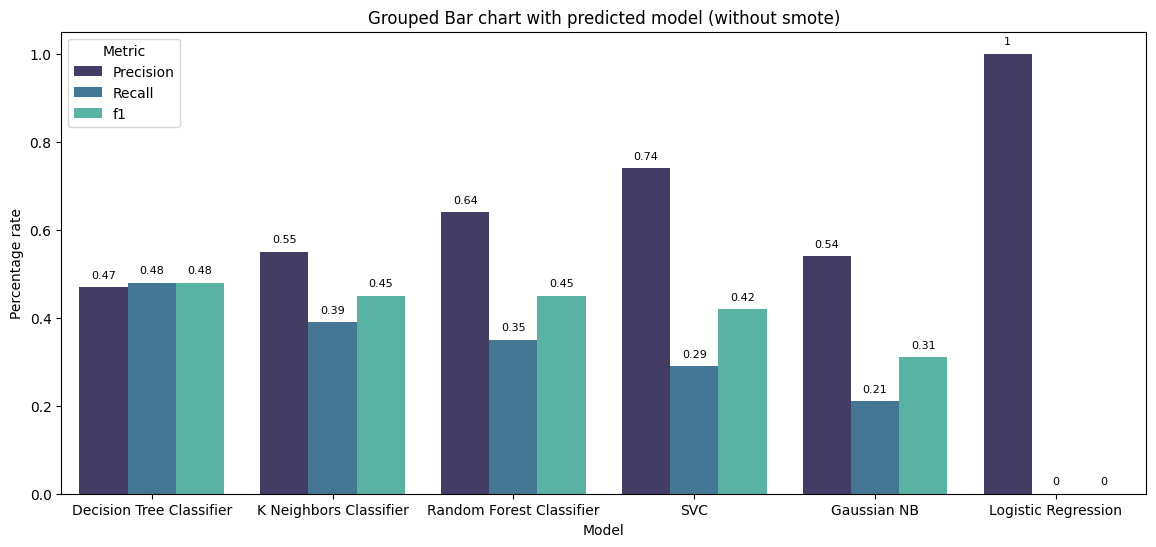

In [150]:
a = bar_chart("without smote")
a.draw_chart(data_no_smote)

{'leaf_size': 2,
 'metric': 'euclidean',
 'n_neighbors': 3,
 'weights': 'distance'}

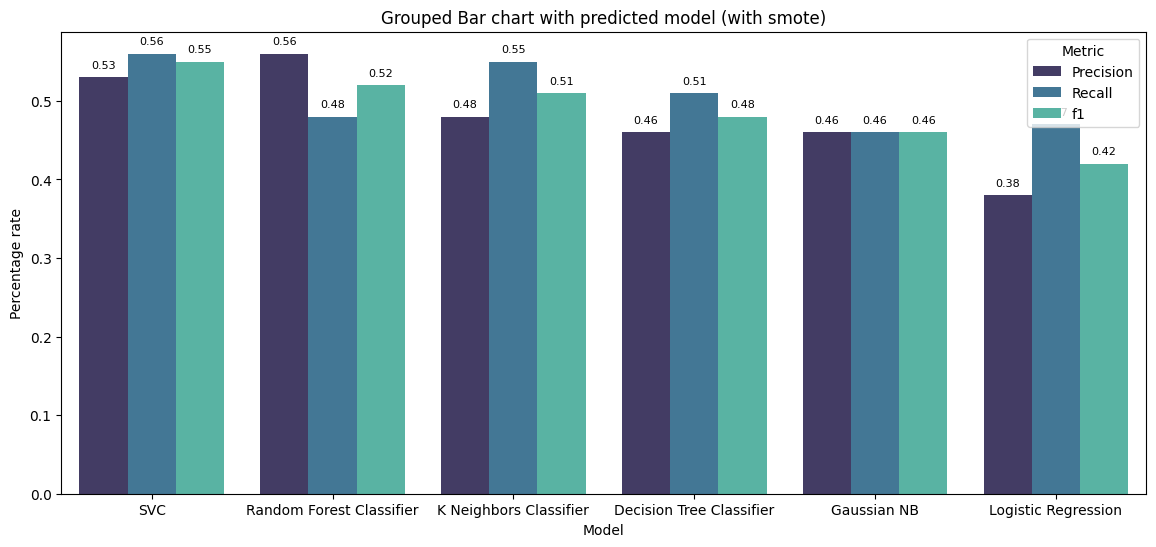

In [151]:
b = bar_chart("with smote")
b.draw_chart(data_score)

###  Evaluation: 
In this project, I explored using an oversampling method, such as SMOTE, to balance the class distribution of the target variable, addressing potential biases introduced by an imbalanced dataset. After applying SMOTE, the model's accuracy and precision showed a slight decline compared to the original version. However, I prioritized improving recall, recognizing that the initial model without oversampling suffered from a very low recall, leading to a poor true positive rate. This adjustment represented a deliberate trade-off to enhance recall at the expense of some accuracy and precision.

Based on the results, classifiers were ranked by their F1-weighted scores, and the top three were selected for in-depth analysis. These included the Support Vector Classifier (SVC), Random Forest Classifier, and KNeighbors Classifier, achieving cross-validation F1-weighted scores of 0.55, 0.52, and 0.51, respectively.

Next, I performed hyperparameter tuning to identify the optimal parameters that maximize the scoring, with a focus on prioritizing recall in this case.

## Hypterparmater tunning 


In [ ]:

# f1 score weighted favors toward recall
ftwo_scorer = make_scorer(fbeta_score, beta=1.5)


In [157]:
grid = {
    'n_neighbors': [3, 5, 7, 9, 11],       # Number of neighbors
    'weights': ['uniform', 'distance'],    # Weighting scheme
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'leaf_size': [2,4,6,8,10]
}


processed_X_train = build_pipeline(smote=False).fit_transform(X_train, y_train)
smote =SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(processed_X_train, y_train)

rf_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid, cv= 5, scoring = ftwo_scorer, n_jobs=-1)
rf_cv.fit(X_train_resampled, y_train_resampled)
rf_cv.best_params_


{'leaf_size': 2,
 'metric': 'euclidean',
 'n_neighbors': 3,
 'weights': 'distance'}

{'leaf_size': 2,
 'metric': 'euclidean',
 'n_neighbors': 3,
 'weights': 'distance'}

In [158]:
grid = {
    'n_estimators': [100,150,200],  # Number of trees
    'max_depth': [None, 10],  # Maximum depth of trees
    'max_features': [None, 'sqrt', 'log2'],  # Number of features for split
    'bootstrap': [True, False],  # Whether to use bootstrap sampling
}

processed_X_train = build_pipeline(smote=False).fit_transform(X_train, y_train)
smote =SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(processed_X_train, y_train)

rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5, scoring = ftwo_scorer, n_jobs=-1)
rf_cv.fit(X_train_resampled, y_train_resampled)
rf_cv.best_params_


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 150}

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 150}

In [159]:
grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
}

processed_X_train = build_pipeline(smote=False).fit_transform(X_train, y_train)
smote =SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(processed_X_train, y_train)

rf_cv = GridSearchCV(estimator=SVC(), param_grid=grid, cv= 5, scoring = ftwo_scorer,  n_jobs=-1)
rf_cv.fit(X_train_resampled, y_train_resampled)
rf_cv.best_params_


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [160]:
top_classifiers = [
    ('SVC',SVC(C=10, gamma = 'scale', kernel = 'rbf', random_state =33, probability=True)),
    ('Random Forest Classifier', RandomForestClassifier(bootstrap =  True, max_depth = None, max_features= 'log2', n_estimators=150,  random_state=33)),
    ('K Neighbors Classifier', KNeighborsClassifier( metric = 'euclidean', n_neighbors =3, leaf_size = 2, p=1, weights='distance')),
]

## ROC Curve Analysis and Model Performance

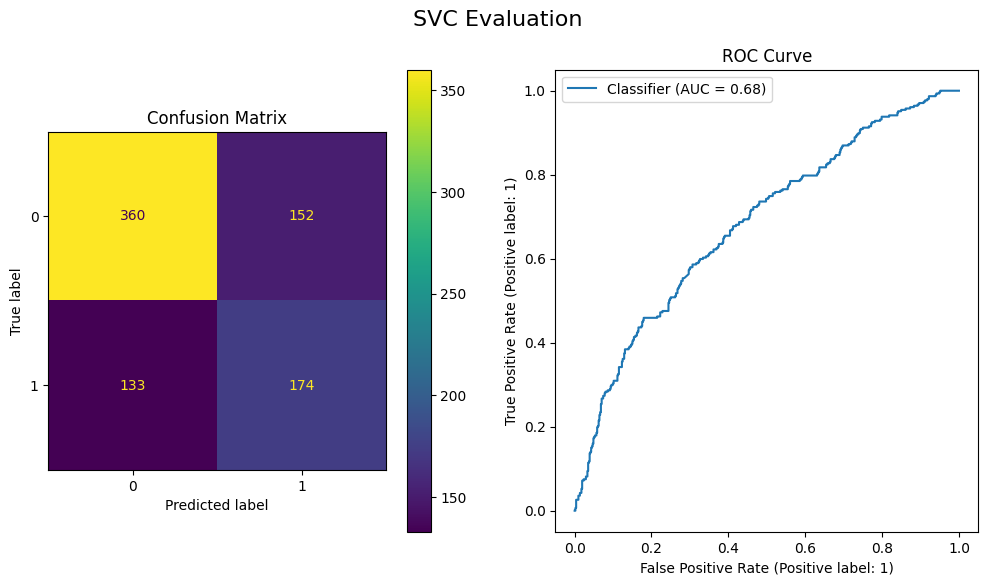

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       512
           1       0.53      0.57      0.55       307

    accuracy                           0.65       819
   macro avg       0.63      0.63      0.63       819
weighted avg       0.66      0.65      0.65       819



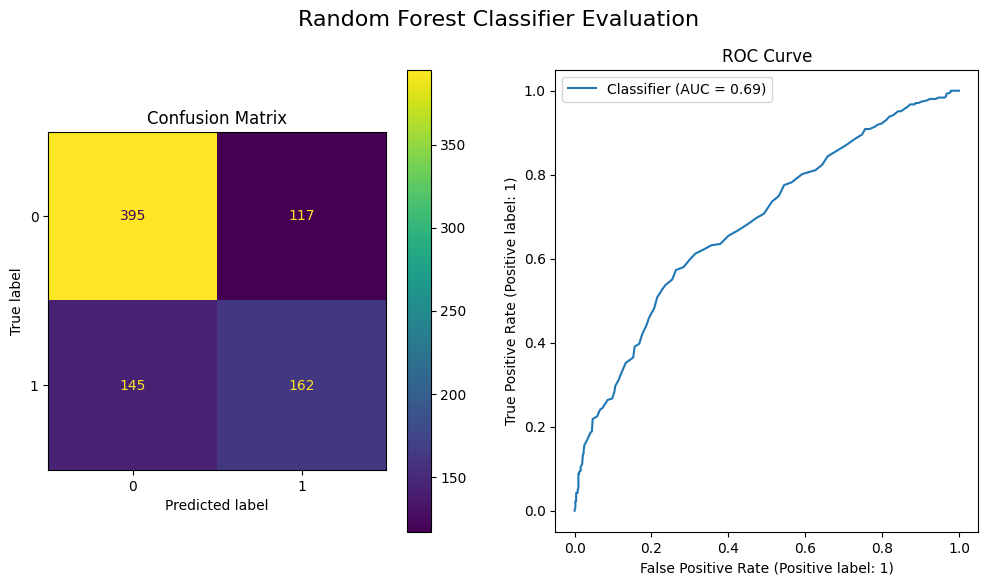

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       512
           1       0.58      0.53      0.55       307

    accuracy                           0.68       819
   macro avg       0.66      0.65      0.65       819
weighted avg       0.67      0.68      0.68       819



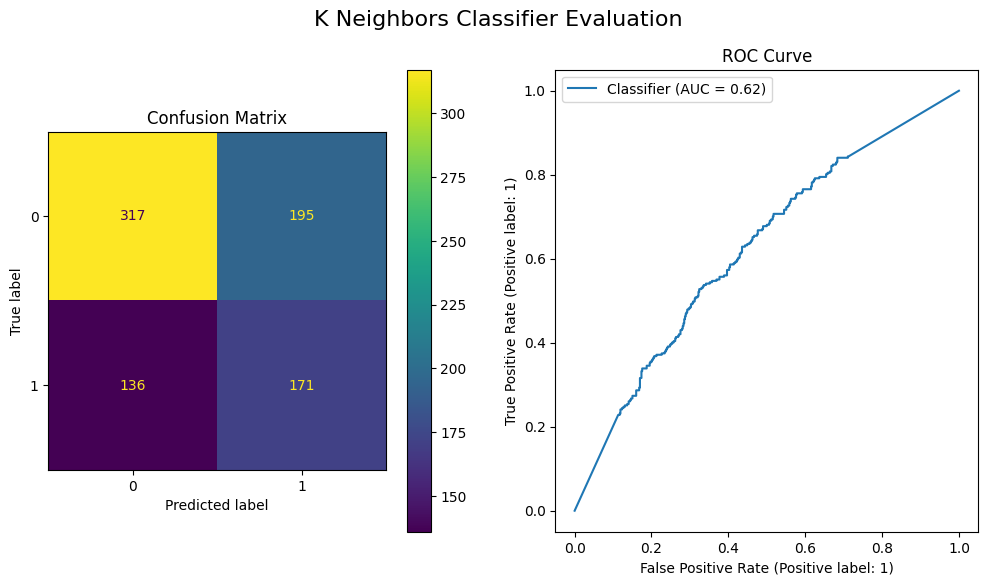

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       512
           1       0.47      0.56      0.51       307

    accuracy                           0.60       819
   macro avg       0.58      0.59      0.58       819
weighted avg       0.61      0.60      0.60       819



In [161]:

def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, title="Classifier Evaluation"):
    """
    Function to fit a classifier, predict, and visualize the confusion matrix and ROC curve.
    """

    # Fit the classifier
    classifier.fit(X_train, y_train)

    # Predict labels and probabilities
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]

    # Create the plots
    fig, [ax_con, ax_roc] = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp_C = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_C.plot(ax=ax_con)
    ax_con.set_title('Confusion Matrix')

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba, drop_intermediate=False, ax=ax_roc)
    ax_roc.set_title('ROC Curve')
    ax_roc.legend()


    plt.show()

    print(classification_report(y_test, y_pred))

for classifier in top_classifiers:
    
    svc_pipeline = build_pipeline(model = classifier[1])
    evaluate_classifier(svc_pipeline, X_train, y_train, X_test, y_test, title=f"{classifier[0]} Evaluation")



## Threshold Optimization and Analysis

In [162]:

def find_best_threshold(yhat, name_classifier):

    print(f"The best thresholod for classifier is {name_classifier} ")
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)

    # Find the threshold that maximizes F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1)]
    print("Best Threshold:", best_threshold)

    new_predicted_labels = (yhat >= best_threshold).astype(int)

    precision = precision_score(y_test, new_predicted_labels)
    recall = recall_score(y_test, new_predicted_labels)
    f1 = f1_score(y_test, new_predicted_labels, average = 'weighted')
    accuracy = accuracy_score(y_test, new_predicted_labels)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    print(classification_report(y_test, new_predicted_labels))


for classifier in top_classifiers:

    pm = build_pipeline(model =classifier[1])
    pm.fit(X_train, y_train)

    y_proba = pm.predict_proba(X_test)
    positive_label = y_proba[:, 1]

    find_best_threshold(positive_label, classifier[0])


The best thresholod for classifier is SVC 
Best Threshold: 0.4631230545394151
Precision: 0.53
Recall: 0.64
F1 Score: 0.65
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       512
           1       0.53      0.64      0.58       307

    accuracy                           0.65       819
   macro avg       0.64      0.65      0.64       819
weighted avg       0.67      0.65      0.65       819

The best thresholod for classifier is Random Forest Classifier 
Best Threshold: 0.36666666666666664
Precision: 0.45
Recall: 0.84
F1 Score: 0.55
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.80      0.39      0.52       512
           1       0.45      0.84      0.59       307

    accuracy                           0.56       819
   macro avg       0.63      0.62      0.56       819
weighted avg       0.67      0.56      0.55       819

The best thresholod for classifier is K Neighbors 

## Conclusion/Reflection :  


| Version      | SVC F1 Score | SVC Recall | KNeighbors F1 Score | KNeighbors Recall | Random Forest F1 Score | Random Forest Recall |
|--------------|--------------|------------|----------------------|-------------------|-------------------------|----------------------|
| Version 1    | 0.55         | 0.56       | 0.51                 | 0.55             | 0.52                    | 0.48                |
| Version 2    | 0.55         | 0.57       | 0.51                 | 0.56             | 0.55                    | 0.53                |
| Version 3    | 0.58         | 0.64       | 0.56                 | 0.79             | 0.59                    | 0.84                |

I prioritized recall over precision, which resulted in the F1 score not being the highest when both precision and recall were equally weighted.

Version 1 represents the results shown in the bar chart, while Version 2 includes the ROC curve, which displays the overall threshold and the parameters for tuning the best classifier. Version 3 focuses on applying the optimal threshold.

Surprisingly, after making several adjustments, the Random Forest classifier emerged as the best performer, showing the most improvement, with its recall value increasing from 0.48 to 0.84. This improvement was especially evident in the skills I was able to implement.
